In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from scipy.spatial import distance
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score,homogeneity_score,contingency_matrix
from SpatialCVGAE.adj import graph
from SpatialCVGAE.train_VGAE import train_model
from SpatialCVGAE.VGAE_model import VGAE
from SpatialCVGAE.utils import *

In [3]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    cm = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)

def seed_everything(random_seed=0):
    seed = random_seed
    import random
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

In [4]:
#run SpatialCVGAE

151508 7
AnnData object with n_obs × n_vars = 4384 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Manual annotation'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
------Calculating spatial graph...
The graph contains 51010 edges, 4384 cells.
11.6355 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 51010 edges, 4384 cells.
11.6355 neighbors per cell on average.
Size of input (4384, 3000)


100%|██████████| 1000/1000 [00:14<00:00, 70.71it/s]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
mclust ari is: 0.5388
mclust nmi is: 0.6403
mclust hs is: 0.6285
mclust purity is: 0.7017
mclust ari is: 0.5543
mclust nmi is: 0.6617
mclust hs is: 0.6502
mclust purity is: 0.7115
151508 7
AnnData object with n_obs × n_vars = 4384 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Manual annotation'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
------Calculating spatial graph...
The graph contains 51010 edges, 4384 cells.
11.6355 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 51010 edges, 4384 cells.
11.6355 neighbors per cell on average.
Size of input (4384, 3000)


100%|██████████| 1000/1000 [00:12<00:00, 80.66it/s]


fitting ...
  |======================================================================| 100%
mclust ari is: 0.5151
mclust nmi is: 0.6311
mclust hs is: 0.6208
mclust purity is: 0.7126
mclust ari is: 0.5298
mclust nmi is: 0.6525
mclust hs is: 0.6419
mclust purity is: 0.7236
151508 7
AnnData object with n_obs × n_vars = 4384 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Manual annotation'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
------Calculating spatial graph...
The graph contains 51010 edges, 4384 cells.
11.6355 neighbors per cell on average.
------Calculating spatial graph...
The graph contains 51010 edges, 4384 cells.
11.6355 neighbors per cell on average.
Size of input (4384, 3000)


100%|██████████| 1000/1000 [00:12<00:00, 78.72it/s]


fitting ...
  |======================================================================| 100%
mclust ari is: 0.5415
mclust nmi is: 0.6333
mclust hs is: 0.6216
mclust purity is: 0.7183
mclust ari is: 0.5584
mclust nmi is: 0.6540
mclust hs is: 0.6415
mclust purity is: 0.7284


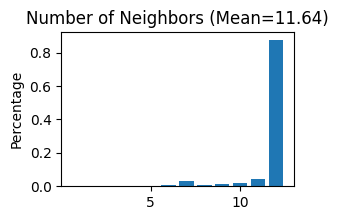

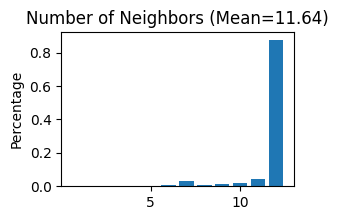

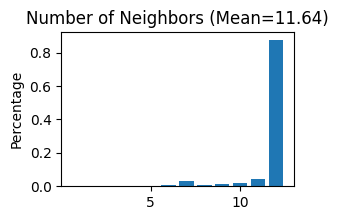

In [5]:
seed_list = [1,2,3]
 
for seed in seed_list:
    seed_everything(seed)
    
    DLPFC_dir = "../../Dataset/DLPFC/"
    
    section_id = '151508'
    
    knn = 7
    
    print(section_id, knn)
    ann_data_raw = sc.read_visium(os.path.join(DLPFC_dir, section_id),
                              count_file=section_id + '_filtered_feature_bc_matrix.h5')
    # load groud truth
    ann_df = pd.read_csv(os.path.join(DLPFC_dir, section_id, section_id + "_truth.txt"),
                         sep="\t", header=None, index_col=0)
    ann_df.columns = ["Manual annotation"]
    ann_data_raw.obs.loc[:, "Manual annotation"] = ann_df.loc[ann_data_raw.obs_names, 'Manual annotation']
    ann_data_raw.var_names_make_unique()
    print(ann_data_raw)
    
    ann_data = ann_data_raw.copy()

    sc.pp.highly_variable_genes(ann_data, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.normalize_total(ann_data, target_sum=1e4)
    sc.pp.log1p(ann_data)

    net = graph(ann_data)
    net.compute_spatial_net()
    net.Stats_Spatial_Net()

    ann_data = train_model(ann_data, input_dim=3000, seed=seed, mse_weight=1, bce_weight=0.1, kld_weight=0.1)

    adata = mclust_R(ann_data, used_obsm='z', num_cluster=knn)
    indices = np.logical_not(ann_data.obs["Manual annotation"].isna())
    ground_truth = ann_data.obs["Manual annotation"].dropna()
    mclust_ari = adjusted_rand_score(ann_data.obs['mclust'][indices], ground_truth[indices])
    print("mclust ari is: {:.4f}".format(mclust_ari))
    mclust_nmi = normalized_mutual_info_score(ann_data.obs['mclust'][indices], ground_truth[indices])
    print("mclust nmi is: {:.4f}".format(mclust_nmi))
    mclust_hs = homogeneity_score(ann_data.obs['mclust'][indices], ground_truth[indices])
    print("mclust hs is: {:.4f}".format(mclust_hs))
    mclust_purity = purity_score(ann_data.obs['mclust'][indices], ground_truth[indices])
    print("mclust purity is: {:.4f}".format(mclust_purity))

    adj_2d = distance.cdist(ann_data.obsm['spatial'], ann_data.obsm['spatial'], 'euclidean')
    refined_pred= refine(sample_id=ann_data.obs.index.tolist(), 
                                 pred=ann_data.obs["mclust"].tolist(), dis=adj_2d, shape="hexagon")
    ann_data.obs["mclust_refine"]= refined_pred
    indices = np.logical_not(ann_data.obs["Manual annotation"].isna())
    ground_truth = ann_data.obs["Manual annotation"].dropna()
    mclust_ari = adjusted_rand_score(ann_data.obs['mclust_refine'][indices], ground_truth[indices])
    print("mclust ari is: {:.4f}".format(mclust_ari))
    mclust_nmi = normalized_mutual_info_score(ann_data.obs['mclust_refine'][indices], ground_truth[indices])
    print("mclust nmi is: {:.4f}".format(mclust_nmi))
    mclust_hs = homogeneity_score(ann_data.obs['mclust_refine'][indices], ground_truth[indices])
    print("mclust hs is: {:.4f}".format(mclust_hs))
    mclust_purity = purity_score(ann_data.obs['mclust_refine'][indices], ground_truth[indices])
    print("mclust purity is: {:.4f}".format(mclust_purity))
    
    file = ann_data.obs['mclust_refine']
    np.save(os.path.join('option 1',section_id,'version_'+str(seed),section_id+'_pred.npy'), file)

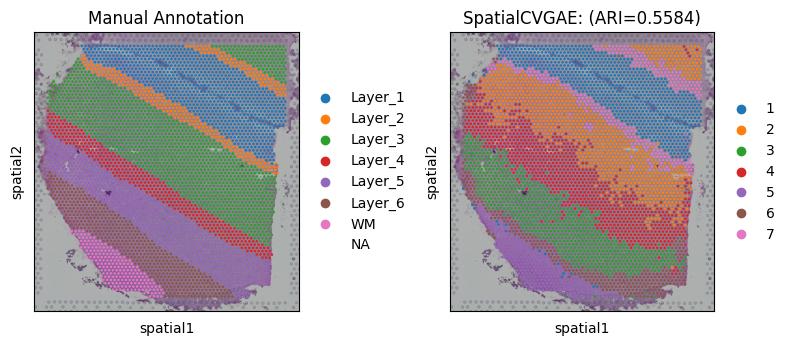

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(4 * 2, 4))
sc.pl.spatial(ann_data, color='Manual annotation', ax=axes[0], show=False)
sc.pl.spatial(ann_data, color='mclust', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('SpatialCVGAE: (ARI=%.4f)' % mclust_ari)
plt.tight_layout()
plt.show()

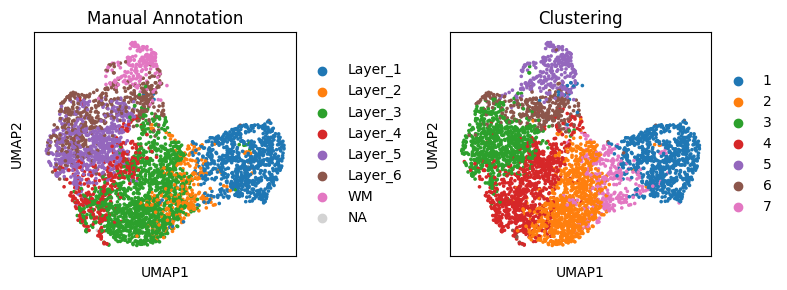

In [7]:
sc.pp.neighbors(ann_data, use_rep='z', metric='cosine',n_pcs=7)
sc.tl.umap(ann_data)

fig, axes = plt.subplots(1,2,figsize=(4*2, 3))
sc.pl.umap(ann_data, color='Manual annotation', ax=axes[0], show=False)
sc.pl.umap(ann_data, color='mclust', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('Clustering')

for ax in axes:
    ax.set_aspect(1)
    
plt.tight_layout()
plt.show()

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

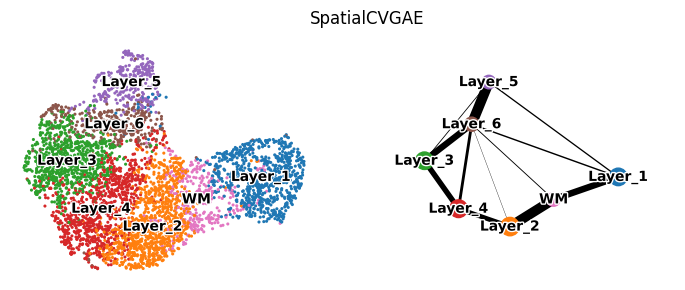

In [8]:
ann_data.obs['mclust_anno'] = ann_data.obs['mclust']
ann_data.obs['mclust_anno'].cat.categories = ['Layer_1','Layer_2','Layer_3','Layer_4','Layer_5','Layer_6','WM']
#ann_data.obs['mclust_anno'].cat.categories = ['Layer_1','Layer_2','Layer_3','Layer_4','WM']
 
sc.tl.paga(ann_data, groups='mclust_anno')

plt.rcParams["figure.figsize"] = (4, 3)
sc.pl.paga_compare(ann_data, legend_fontsize=10, frameon=False, size=20,
                   title='SpatialCVGAE', legend_fontoutline=2, show=False)

In [9]:
#SVGs identification

In [10]:
import SpaGCN as spg
import matplotlib.colors as clr
from scipy.sparse import issparse

raw = sc.read_visium(os.path.join(DLPFC_dir, section_id),
                          count_file=section_id + '_filtered_feature_bc_matrix.h5')
raw.var_names_make_unique()
raw.obs["pred"]=ann_data.obs["mclust_refine"].astype('category')
raw.obs["x_array"]=raw.obs["array_row"]
raw.obs["y_array"]=raw.obs["array_col"]
raw.obs["x_pixel"] = raw.obsm['spatial'][:,0]
raw.obs["y_pixel"] = raw.obsm['spatial'][:,1]
x_array = raw.obs["x_array"].tolist()
y_array = raw.obs["y_array"].tolist()
x_pixel = raw.obs["x_pixel"].tolist()
y_pixel = raw.obs["y_pixel"].tolist()
raw.X = (raw.X.A if issparse(raw.X) else raw.X)
raw.raw = raw
sc.pp.log1p(raw)

In [11]:
#Use domain 0 as an example
target=1
#Set filtering criterials
min_in_group_fraction=0.8
min_in_out_group_ratio=1
min_fold_change=1.5
#Search radius such that each spot in the target domain has approximately 10 neighbors on average
adj_2d=spg.calculate_adj_matrix(x=x_array, y=y_array, histology=False)
start, end= np.quantile(adj_2d[adj_2d!=0],q=0.001), np.quantile(adj_2d[adj_2d!=0],q=0.1)
r=spg.search_radius(target_cluster=target, cell_id=ann_data.obs.index.tolist(), x=x_array, y=y_array, pred=ann_data.obs["mclust_refine"].tolist(), start=start, end=end, num_min=10, num_max=100,  max_run=100)
#Detect neighboring domains
nbr_domians=spg.find_neighbor_clusters(target_cluster=target,
                                   cell_id=raw.obs.index.tolist(), 
                                   x=raw.obs["x_array"].tolist(), 
                                   y=raw.obs["y_array"].tolist(), 
                                   pred=raw.obs["pred"].tolist(),
                                   radius=r,
                                   ratio=1/2)
nbr_domians=nbr_domians[0:3]
de_genes_info=spg.rank_genes_groups(input_adata=raw,
                                target_cluster=target,
                                nbr_list=nbr_domians, 
                                label_col="pred", 
                                adj_nbr=True, 
                                log=True)
#Filter genes
de_genes_info=de_genes_info[(de_genes_info["pvals_adj"]<0.05)]
filtered_info=de_genes_info
filtered_info=filtered_info[(filtered_info["pvals_adj"]<0.05) &
                            (filtered_info["in_out_group_ratio"]>min_in_out_group_ratio) &
                            (filtered_info["in_group_fraction"]>min_in_group_fraction) &
                            (filtered_info["fold_change"]>min_fold_change)]
filtered_info=filtered_info.sort_values(by="in_group_fraction", ascending=False)
filtered_info["target_dmain"]=target
filtered_info["neighbors"]=str(nbr_domians)
print("SVGs for domain ", str(target),":", filtered_info["genes"].tolist())

Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Calculateing adj matrix using xy only...
Run 1: radius [2.0, 18.384777069091797], num_nbr [8.782608695652174, 423.295652173913]
Calculateing adj matrix using xy only...
Run 2: radius [2.0, 10.192388534545898], num_nbr [8.782608695652174, 142.92670807453416]
Calculateing adj matrix using xy only...
recommended radius =  6.096194267272949 num_nbr=56.874534161490686
radius= 6.096194267272949 average number of neighbors for each spot is 56.874534161490686
 Cluster 1 has neighbors:
Dmain  7 :  5344
Dmain  2 :  1331
SVGs for domain  1 : ['GFAP']


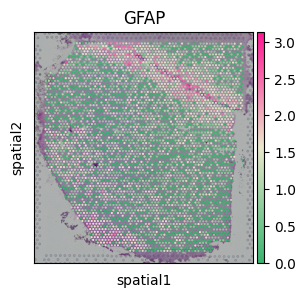

In [12]:
gene_list = ['GFAP']

color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)
for g in gene_list:
    raw.obs["exp"]=raw.X[:,raw.var.index==g]
    sc.pl.spatial(raw, img_key="hires",
              color="exp",
              title=g,
              color_map=color_self)

Add gene:  SNORC
Minus gene:  FTH1
Absolute mean change: 1.6298026
Number of non-target spots reduced to: 406
Meta gene is:  GFAP+SNORC-FTH1
Add gene:  CST3
Minus gene:  MBP
Absolute mean change: 2.3512428
Number of non-target spots reduced to: 67
Meta gene is:  GFAP+SNORC-FTH1+CST3-MBP
Add gene:  MBP
Minus gene:  NRGN
Absolute mean change: 2.768248
Number of non-target spots reduced to: 62
Meta gene is:  GFAP+SNORC-FTH1+CST3-MBP+MBP-NRGN


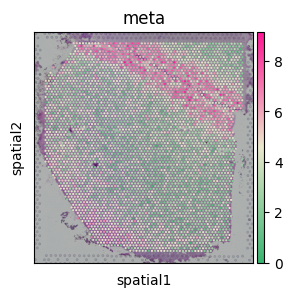

In [13]:
target=1
meta_name, meta_exp=spg.find_meta_gene(input_adata=raw,
                    pred=raw.obs["pred"].tolist(),
                    target_domain=target,
                    start_gene="GFAP",
                    mean_diff=0,
                    early_stop=True,
                    max_iter=3,
                    use_raw=False)

raw.obs["meta"]=meta_exp
raw.obs["exp"]=raw.obs["meta"]
sc.pl.spatial(raw, img_key="hires",
              color="exp",
              title='meta',
              color_map=color_self)

In [14]:
#consensus clustering

In [15]:
import glob
import itertools
from typing import List
from scipy.spatial import distance
from scipy.cluster import hierarchy


def labels_connectivity_mat(labels: np.ndarray):
    _labels = labels - np.min(labels)
    n_classes = np.unique(_labels)
    mat = np.zeros([labels.size, labels.size])
    for i in n_classes:
        indices = np.squeeze(np.where(_labels == i))  #将属于各个类的标签提取出来
        row_indices, col_indices = zip(*itertools.product(indices, indices))
        mat[row_indices, col_indices] = 1
    return mat


def consensus_matrix(labels_list: List[np.ndarray]):
    mat = 0
    for labels in labels_list:
        mat += labels_connectivity_mat(labels)
    return mat / float(len(labels_list))


def plot_consensus_map(cmat, method="average", return_linkage=True, **kwargs):
    row_linkage = hierarchy.linkage(distance.pdist(cmat), method=method)
    col_linkage = hierarchy.linkage(distance.pdist(cmat.T), method=method)
    figure = sns.clustermap(cmat, row_linkage=row_linkage, col_linkage=col_linkage, **kwargs)
    if return_linkage:
        return row_linkage, col_linkage, figure
    else:
        return figure

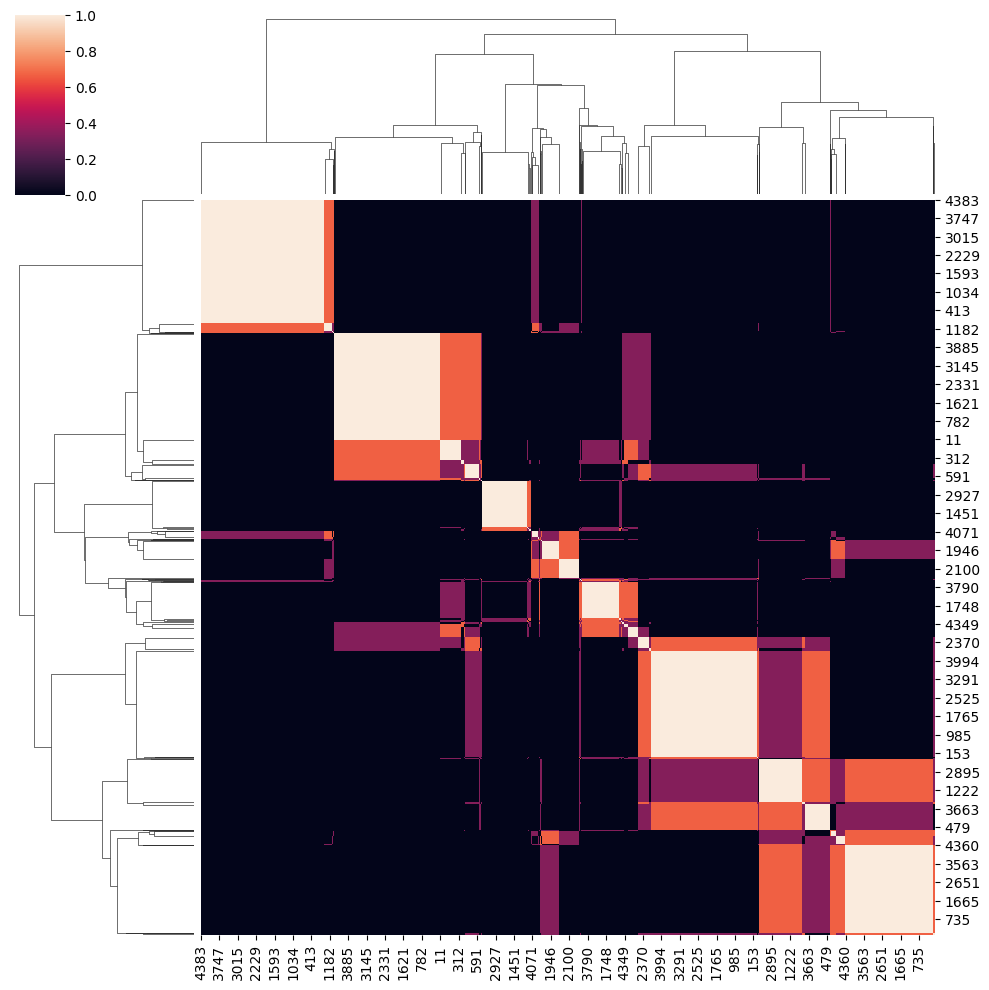

In [18]:
save_dir = os.path.join('option 1',section_id)
name = section_id+"_pred.npy"
num_cluster = knn

sys.setrecursionlimit(100000)
label_files = glob.glob(save_dir + f"/version_*/{name}")
labels_list = list(map(lambda file: np.load(file), label_files))
cons_mat = consensus_matrix(labels_list)
row_linkage, _, figure = plot_consensus_map(cons_mat, return_linkage=True)  # 获取层次聚类结果和热度图
figure.savefig(os.path.join(save_dir, "consensus_clustering.png"), dpi=300)  # 保存图片
consensus_labels = hierarchy.cut_tree(row_linkage, num_cluster).squeeze()  # 得到y*
np.save(os.path.join(save_dir, "consensus_labels"), consensus_labels)

In [19]:
pred = np.load(os.path.join('option 1',section_id,'consensus_labels.npy'))
indices = np.logical_not(ann_data.obs["Manual annotation"].isna())
ground_truth = ann_data.obs["Manual annotation"].dropna()
ari = adjusted_rand_score(pred[indices], ground_truth[indices])
print("ari is: {:.4f}".format(ari))
nmi = normalized_mutual_info_score(pred[indices], ground_truth[indices])
print("nmi is: {:.4f}".format(nmi))
hs = homogeneity_score(pred[indices], ground_truth[indices])
print("hs is: {:.4f}".format(hs))
purity = purity_score(pred[indices], ground_truth[indices])
print("purity is: {:.4f}".format(purity))

ari is: 0.5848
nmi is: 0.6713
hs is: 0.6598
purity is: 0.7421
